# Предсказание стоимости жилья

**Описание и цели проекта:**
В рамках данного проекта  необходимо:
- обучить модель линейной регрессии на данных о жилье в Калифорнии в 1990 году;
- выполнить предсказание медианной стоимость дома в жилом массиве;
- обучить модель и сделать предсказания на тестовой выборке;
- для оценки качества модели использовать метрики RMSE, MAE и R2.

**Описание данных:**

*longitude* — широта;  

*latitude* — долгота;  

*housing_median_age* — медианный возраст жителей жилого массива;  

*total_rooms* — общее количество комнат в домах жилого массива;  

*total_bedrooms* — общее количество спален в домах жилого массива;  

*population* — количество человек, которые проживают в жилом массиве;  

*households* — количество домовладений в жилом массиве;  

*median_income* — медианный доход жителей жилого массива;  

*median_house_value* — медианная стоимость дома в жилом массиве;  

*ocean_proximity* — близость к океану.

**План работы:**
    
1. [Инициализация локальной Spark-сессии](#section_id)  


2. [Чтение и загрузка необходимых данных](#section_id2)  


3. [Предобработка данных:](#section_id3)  

- исследовать данные на наличие пропусков и заполнить их, при наличии
- преобразовать колонки с категориальными значениями (при наличии) техникой One hot encoding.
- преобразовать колонки с количественными значениями c помощью StandardScaler

4. [Построение моделей линейной регрессии на разных наборах данных:](#section_id4)  

- использовать все данные из файла;
- используя только числовые признаки, исключив категориальные
- используя все данные из файла + синтетические данные
- используя только числовые признаки + синтетические данные

5. [Сравнение результатов работы модели на разных наборах данных.Выводы.](#section_id5)  

Импортируем необходимые для выполнения исследования библиотеки и константы:

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
!pip install --upgrade pyspark
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import warnings 
warnings.filterwarnings('ignore')

In [2]:
pyspark.__version__

'3.5.2'

In [3]:
RANDOM_SEED = 42

# Инициализация локальной Spark-сессии <a id='section_id'></a>

Инициализируем локальную Spark - сессию:

In [4]:
spark = SparkSession.builder \
                    .master('local') \
                    .appName('California_housing') \
                    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/19 17:15:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


**Вывод:** Локальная Spark-сессия запущена 
<a id='section_id2'></a>

# Чтение и загрузка необходимых данных

Загрузим необходимые для выполнения исследрвания данные:

In [5]:
df = spark.read.load('/datasets/housing.csv', format='csv', inferSchema=True, header = 'true')

Проверим, что данные загружены корректно и выведем первые 5 строк датафрейма

In [6]:
df.show(5)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

Выведем типы данных данных в столбцах:

In [8]:
df.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



Выведем базовые статистичнсеские показатели датафрейма:

In [9]:
df.describe().toPandas().T

24/08/19 17:15:39 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,0,1,2,3,4
summary,count,mean,stddev,min,max
longitude,20640,-119.56970445736148,2.003531723502584,-124.35,-114.31
latitude,20640,35.6318614341087,2.135952397457101,32.54,41.95
housing_median_age,20640,28.639486434108527,12.58555761211163,1.0,52.0
total_rooms,20640,2635.7630813953488,2181.6152515827944,2.0,39320.0
total_bedrooms,20433,537.8705525375618,421.38507007403115,1.0,6445.0
population,20640,1425.4767441860465,1132.46212176534,3.0,35682.0
households,20640,499.5396802325581,382.3297528316098,1.0,6082.0
median_income,20640,3.8706710029070246,1.899821717945263,0.4999,15.0001
median_house_value,20640,206855.81690891474,115395.61587441359,14999.0,500001.0


**Вывод:**  Необходимые для выполнения исследования данные, успешно загружены. Выведены типы данных параметров методами pySpark. Выведены базовые статистики по столбцам датафрейма.
<a id='section_id3'></a>

# Предобработка данных

Исследуем данные на наличие пропусков:

In [10]:
columns = df.columns

for column in columns:
    check_col = F.col(column).isNull()
    print(column, df.filter(check_col).count())

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 207
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


Обнаружено 207 пропущенных значений в столбце 'total_bedrooms'. Заменим их на  медианное значение по данному столбцу. 

In [11]:
df = df.fillna(df.agg(F.median('total_bedrooms')).collect()[0][0], 'total_bedrooms')

Выполним замену пропусков в столбце 'total_bedrooms' на медианное значение по данному столбцу.

Проверим результат проведенной замены:

In [12]:
columns = df.columns

for column in columns:
    check_col = F.col(column).isNull()
    print(column, df.filter(check_col).count())

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 0
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


Пропуски в датафрейме устранены.

Подготовим датасет для последующей работы с моделью.   
Выделим колонки содержащие категориальные и количественные признаки, а также таргет:

In [13]:
categorical_cols = 'ocean_proximity'
numerical_cols  = [
    'longitude', 'latitude', 'housing_median_age', 
    'total_rooms', 'total_bedrooms', 'population', 
    'households', 'median_income'
]
target = 'median_house_value'

Также, разделим датасет на обучающую и тестовую выборки:

In [14]:
train_data, test_data = df.randomSplit([.8,.2], seed=RANDOM_SEED)
print(train_data.count(), test_data.count()) 

16560 4080


Выполним преобразование колонки 'ocean_proximity' с категориальными значениями техникой One hot encoding. Для этого предварительно преобразуем значения столбца 'ocean_proximity' из строкового формата в числовой с помощью StringIndexer:

In [15]:
indexer = StringIndexer(inputCols = ['ocean_proximity'], 
                        outputCols = ['ocean_proximity_idx']).fit(train_data) 

train_data = indexer.transform(train_data)
test_data = indexer.transform(test_data) 

cols = [c for c in train_data.columns if (c.startswith('o'))]

train_data.select(cols).show(5) 

test_data.select(cols).show(5) 


+---------------+-------------------+
|ocean_proximity|ocean_proximity_idx|
+---------------+-------------------+
|     NEAR OCEAN|                2.0|
|     NEAR OCEAN|                2.0|
|     NEAR OCEAN|                2.0|
|     NEAR OCEAN|                2.0|
|     NEAR OCEAN|                2.0|
+---------------+-------------------+
only showing top 5 rows

+---------------+-------------------+
|ocean_proximity|ocean_proximity_idx|
+---------------+-------------------+
|     NEAR OCEAN|                2.0|
|     NEAR OCEAN|                2.0|
|     NEAR OCEAN|                2.0|
|     NEAR OCEAN|                2.0|
|     NEAR OCEAN|                2.0|
+---------------+-------------------+
only showing top 5 rows



Затем выполним дополнительную обработку значений с помощью One hot encoding

In [16]:
encoder = OneHotEncoder(inputCols = ['ocean_proximity_idx'],
                        outputCols = ['ocean_proximity_ohe']).fit(train_data)
train_data = encoder.transform(train_data)

test_data = encoder.transform(test_data)

cols = [c for c in train_data.columns if (c.startswith('o'))]

train_data.select(cols).show(5) 

test_data.select(cols).show(5) 

+---------------+-------------------+-------------------+
|ocean_proximity|ocean_proximity_idx|ocean_proximity_ohe|
+---------------+-------------------+-------------------+
|     NEAR OCEAN|                2.0|      (4,[2],[1.0])|
|     NEAR OCEAN|                2.0|      (4,[2],[1.0])|
|     NEAR OCEAN|                2.0|      (4,[2],[1.0])|
|     NEAR OCEAN|                2.0|      (4,[2],[1.0])|
|     NEAR OCEAN|                2.0|      (4,[2],[1.0])|
+---------------+-------------------+-------------------+
only showing top 5 rows

+---------------+-------------------+-------------------+
|ocean_proximity|ocean_proximity_idx|ocean_proximity_ohe|
+---------------+-------------------+-------------------+
|     NEAR OCEAN|                2.0|      (4,[2],[1.0])|
|     NEAR OCEAN|                2.0|      (4,[2],[1.0])|
|     NEAR OCEAN|                2.0|      (4,[2],[1.0])|
|     NEAR OCEAN|                2.0|      (4,[2],[1.0])|
|     NEAR OCEAN|                2.0|      (4,[

Объеденим полученные признаки в единый вектор. для дальнейшего использования в модели МО:

In [17]:
categorical_assembler = (
        VectorAssembler(inputCols=['ocean_proximity_ohe'],
                        outputCol='categorical_feature')
)

train_data = categorical_assembler.transform(train_data) 

test_data = categorical_assembler.transform(test_data) 

Отмасштабируем столбцы с количественными значениями:

In [18]:
numerical_assembler = (
    VectorAssembler(inputCols=numerical_cols,
                    outputCol='numerical_features')
)

train_data = numerical_assembler.transform(train_data)

test_data = numerical_assembler.transform(test_data)

Отмасштабируем значения количественных параметров с помощью StandardScaler:

In [19]:
standardScaler = (
    StandardScaler(inputCol='numerical_features',
                   outputCol="numerical_features_scaled").fit(train_data)
)

train_data = standardScaler.transform(train_data) 

test_data = standardScaler.transform(test_data) 

Выведем все столбцы датафрейма с учетом произведенных преобразований:

In [20]:
for col in train_data.columns:
    print(col)

longitude
latitude
housing_median_age
total_rooms
total_bedrooms
population
households
median_income
median_house_value
ocean_proximity
ocean_proximity_idx
ocean_proximity_ohe
categorical_feature
numerical_features
numerical_features_scaled


In [21]:
for col in test_data.columns:
    print(col)

longitude
latitude
housing_median_age
total_rooms
total_bedrooms
population
households
median_income
median_house_value
ocean_proximity
ocean_proximity_idx
ocean_proximity_ohe
categorical_feature
numerical_features
numerical_features_scaled


Соберем финально обработанные признаки в итоговый вектор:

In [22]:
all_features = ['categorical_feature','numerical_features_scaled']

final_assembler = VectorAssembler(inputCols=all_features, 
                                  outputCol='features') 
train_data = final_assembler.transform(train_data)

test_data = final_assembler.transform(test_data)


train_data.select(all_features).show(5) 
test_data.select(all_features).show(5) 

+-------------------+-------------------------+
|categorical_feature|numerical_features_scaled|
+-------------------+-------------------------+
|      (4,[2],[1.0])|     [-61.931952286653...|
|      (4,[2],[1.0])|     [-61.907050013920...|
|      (4,[2],[1.0])|     [-61.892108650280...|
|      (4,[2],[1.0])|     [-61.887128195733...|
|      (4,[2],[1.0])|     [-61.882147741187...|
+-------------------+-------------------------+
only showing top 5 rows

+-------------------+-------------------------+
|categorical_feature|numerical_features_scaled|
+-------------------+-------------------------+
|      (4,[2],[1.0])|     [-61.907050013920...|
|      (4,[2],[1.0])|     [-61.872186832094...|
|      (4,[2],[1.0])|     [-61.872186832094...|
|      (4,[2],[1.0])|     [-61.852265013907...|
|      (4,[2],[1.0])|     [-61.847284559361...|
+-------------------+-------------------------+
only showing top 5 rows



**Выводы:**  В рамках предобработки данных датасет проверен на наличие пропусков. Выявлены пропуски в столбце 'total_bedroms', заменены на медианное значение по данному столбцу. Также столбец 'ocean_proximity' содержащий категориальные значения, обработан с помощью StringIndexer и OneHotEncoder, количественные признаки обработаны с помощью StandardScaler. Все трансформированные признаки собраны в итоговый вектор.
<a id='section_id4'></a>

# Построение моделей линейной регрессии на разных наборах данных:


## Модель линейной регрессии с использованием категориальных и количественных признаков:

Инициализируем и обучим модельь линейной регрессии:

In [23]:
lr = LinearRegression(labelCol=target, featuresCol='features')

model = lr.fit(train_data) 

24/08/19 17:16:06 WARN Instrumentation: [b811786a] regParam is zero, which might cause numerical instability and overfitting.
24/08/19 17:16:06 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/08/19 17:16:07 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Получим предсказания на тестовой выборке:

In [24]:
predictions = model.transform(test_data)

predictedLabes = predictions.select('median_house_value', 'prediction')
predictedLabes.show(10) 

+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|          103600.0|150533.04666316602|
|          106700.0| 217624.6519294884|
|           73200.0|125169.93075912353|
|           90100.0| 195019.3159925216|
|           67000.0|152291.13957492262|
|           86400.0| 186076.1616788553|
|           70500.0|163936.40808554646|
|           85100.0|180008.60114514176|
|           80500.0|181580.61779531697|
|           96000.0|170314.90779798012|
+------------------+------------------+
only showing top 10 rows



Вычислим метрики качества работы модели RMSE, MAE, R2:

In [25]:
print("RMSE: ", model.summary.rootMeanSquaredError)
print("MAE: ", model.summary.meanAbsoluteError)
print("R-squared: ", model.summary.r2) 

RMSE:  68275.64811234415
MAE:  49529.28174129566
R-squared:  0.6462958477899968


## Модель линейной регрессии с использованием только количественных признаков:

Выполним обучение и предсказание таргета, используя только количественные переменные:

In [26]:
lr_num = LinearRegression(labelCol=target, featuresCol='numerical_features_scaled')

model_num = lr_num.fit(train_data) 

24/08/19 17:16:10 WARN Instrumentation: [358fc9c1] regParam is zero, which might cause numerical instability and overfitting.


Получим предсказания на тестовой выборке:

In [27]:
predictions = model_num.transform(test_data)

predictedLabes = predictions.select('median_house_value', 'prediction')
predictedLabes.show(10) 

+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|          103600.0|100751.20280909259|
|          106700.0|190787.23973705387|
|           73200.0| 74736.22098583262|
|           90100.0|162342.36984607764|
|           67000.0| 119469.7378415009|
|           86400.0| 155921.9725331883|
|           70500.0|131193.75530479848|
|           85100.0|150446.14696751628|
|           80500.0|150167.76520445198|
|           96000.0| 133759.4025147278|
+------------------+------------------+
only showing top 10 rows



Вычислим метрики качества работы модели RMSE, MAE, R2:

In [28]:
print("RMSE: ", model_num.summary.rootMeanSquaredError)
print("MAE: ", model_num.summary.meanAbsoluteError)
print("R-squared: ", model_num.summary.r2) 

RMSE:  69208.31730808293
MAE:  50642.13150832837
R-squared:  0.6365664003046897


## Модель линейной регрессии с использованием категориальных и количественных признаков + синтетические признаки:

Добавим синтетические количественные признаки, такие как:
- rooms_per_household: отношение общего количества комнат на одно домовладение;
- population_in_household: количество жильцов в одном домовладении
- bedroom_index: отношение количества спальных комнат к общему числу комнат

In [29]:
df_sint = (
    df
      .select(
        [
            'longitude', 'latitude', 'housing_median_age', 'total_rooms',
        'total_bedrooms', 'population', 'households', 'median_income',
        'median_house_value', 'ocean_proximity'
        ]
      )
      .withColumn('rooms_per_household', F.col('total_rooms') / F.col('households'))
      .withColumn('population_in_household', F.col('population') / F.col('households'))
      .withColumn('bedroom_index', F.col('total_bedrooms') / F.col('total_rooms'))
)
df_sint.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = false)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)
 |-- rooms_per_household: double (nullable = true)
 |-- population_in_household: double (nullable = true)
 |-- bedroom_index: double (nullable = true)



Добавим полученные признаки в список с количественными переменными:

In [30]:
numerical_cols  = [
    'longitude', 'latitude', 'housing_median_age', 
    'total_rooms', 'total_bedrooms', 'population', 
    'households', 'median_income', 'rooms_per_household', 
    'population_in_household', 'bedroom_index']

Разделим датасет на выборки:

In [31]:
train_data, test_data = df_sint.randomSplit([.8,.2], seed=RANDOM_SEED)

Выполним кодирование категориальных переменных

In [32]:
indexer = StringIndexer(inputCols = ['ocean_proximity'], 
                        outputCols = ['ocean_proximity_idx']).fit(train_data) 

train_data = indexer.transform(train_data)

test_data = indexer.transform(test_data)

cols = [c for c in train_data.columns if (c.startswith('o'))]

train_data.select(cols).show(5) 
test_data.select(cols).show(5) 

+---------------+-------------------+
|ocean_proximity|ocean_proximity_idx|
+---------------+-------------------+
|     NEAR OCEAN|                2.0|
|     NEAR OCEAN|                2.0|
|     NEAR OCEAN|                2.0|
|     NEAR OCEAN|                2.0|
|     NEAR OCEAN|                2.0|
+---------------+-------------------+
only showing top 5 rows

+---------------+-------------------+
|ocean_proximity|ocean_proximity_idx|
+---------------+-------------------+
|     NEAR OCEAN|                2.0|
|     NEAR OCEAN|                2.0|
|     NEAR OCEAN|                2.0|
|     NEAR OCEAN|                2.0|
|     NEAR OCEAN|                2.0|
+---------------+-------------------+
only showing top 5 rows



In [33]:
encoder = OneHotEncoder(inputCols = ['ocean_proximity_idx'],
                        outputCols = ['ocean_proximity_ohe']).fit(train_data) 

train_data = encoder.transform(train_data)

test_data = encoder.transform(test_data)

cols = [c for c in train_data.columns if (c.startswith('o'))]

train_data.select(cols).show(5) 
test_data.select(cols).show(5) 

+---------------+-------------------+-------------------+
|ocean_proximity|ocean_proximity_idx|ocean_proximity_ohe|
+---------------+-------------------+-------------------+
|     NEAR OCEAN|                2.0|      (4,[2],[1.0])|
|     NEAR OCEAN|                2.0|      (4,[2],[1.0])|
|     NEAR OCEAN|                2.0|      (4,[2],[1.0])|
|     NEAR OCEAN|                2.0|      (4,[2],[1.0])|
|     NEAR OCEAN|                2.0|      (4,[2],[1.0])|
+---------------+-------------------+-------------------+
only showing top 5 rows

+---------------+-------------------+-------------------+
|ocean_proximity|ocean_proximity_idx|ocean_proximity_ohe|
+---------------+-------------------+-------------------+
|     NEAR OCEAN|                2.0|      (4,[2],[1.0])|
|     NEAR OCEAN|                2.0|      (4,[2],[1.0])|
|     NEAR OCEAN|                2.0|      (4,[2],[1.0])|
|     NEAR OCEAN|                2.0|      (4,[2],[1.0])|
|     NEAR OCEAN|                2.0|      (4,[

In [34]:
categorical_assembler = (
        VectorAssembler(inputCols=['ocean_proximity_ohe'],
                        outputCol='categorical_feature')
)

train_data = categorical_assembler.transform(train_data) 
test_data = categorical_assembler.transform(test_data) 

Отмасштабируем количественные переменные:

In [35]:
numerical_assembler = (
    VectorAssembler(inputCols=numerical_cols,
                    outputCol='numerical_features')
)

train_data = numerical_assembler.transform(train_data)
test_data = numerical_assembler.transform(test_data) 

In [36]:
standardScaler = (
    StandardScaler(inputCol='numerical_features',
                   outputCol="numerical_features_scaled_sint").fit(train_data)
)

train_data = standardScaler.transform(train_data) 
test_data = standardScaler.transform(test_data) 

Объеденим обработанные параметры в единый вектор:

In [37]:
all_features = ['categorical_feature','numerical_features_scaled_sint']

final_assembler = VectorAssembler(inputCols=all_features, 
                                  outputCol='features') 
train_data = final_assembler.transform(train_data)
test_data = final_assembler.transform(test_data)

train_data.select(all_features).show(5) 
test_data.select(all_features).show(5) 

+-------------------+------------------------------+
|categorical_feature|numerical_features_scaled_sint|
+-------------------+------------------------------+
|      (4,[2],[1.0])|          [-61.931952286653...|
|      (4,[2],[1.0])|          [-61.907050013920...|
|      (4,[2],[1.0])|          [-61.892108650280...|
|      (4,[2],[1.0])|          [-61.887128195733...|
|      (4,[2],[1.0])|          [-61.882147741187...|
+-------------------+------------------------------+
only showing top 5 rows

+-------------------+------------------------------+
|categorical_feature|numerical_features_scaled_sint|
+-------------------+------------------------------+
|      (4,[2],[1.0])|          [-61.907050013920...|
|      (4,[2],[1.0])|          [-61.872186832094...|
|      (4,[2],[1.0])|          [-61.872186832094...|
|      (4,[2],[1.0])|          [-61.852265013907...|
|      (4,[2],[1.0])|          [-61.847284559361...|
+-------------------+------------------------------+
only showing top 5 ro

Обучим модель:

In [38]:
lr_sint = LinearRegression(labelCol=target, featuresCol='features')

model_sint = lr_sint.fit(train_data) 

24/08/19 17:16:19 WARN Instrumentation: [b86dec75] regParam is zero, which might cause numerical instability and overfitting.


Получим предсказания:

In [39]:
predictions = model_sint.transform(test_data)

predictedLabes = predictions.select('median_house_value', 'prediction')
predictedLabes.show(10) 

+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|          103600.0| 143149.1305572451|
|          106700.0|211487.42533095786|
|           73200.0|116373.69551048987|
|           90100.0|189979.04517336376|
|           67000.0|   147965.61785752|
|           86400.0|180114.74099615915|
|           70500.0|158470.41957549006|
|           85100.0|175297.91066487553|
|           80500.0| 179603.7597574396|
|           96000.0|164368.05219191546|
+------------------+------------------+
only showing top 10 rows



Вычислим метрики качества работы модели RMSE, MAE, R2, с учетом синтетических признаков:

In [40]:
print("RMSE: ", model_sint.summary.rootMeanSquaredError)
print("MAE: ", model_sint.summary.meanAbsoluteError)
print("R-squared: ", model_sint.summary.r2) 

RMSE:  67603.84182770473
MAE:  48897.450947981124
R-squared:  0.6532222301999069


## Модель линейной регрессии с использованием только количественных признаков + синтетические признаки:

Выполним обучение и предсказание таргета, используя только количественные переменные, с учетом синтетических признаков, добавленных в предыдущем раздлеле:

Обучим модель:

In [41]:
lr_sint_num = LinearRegression(labelCol=target, featuresCol='numerical_features_scaled_sint')

model_sint_num = lr_sint_num.fit(train_data) 

24/08/19 17:16:22 WARN Instrumentation: [f285a085] regParam is zero, which might cause numerical instability and overfitting.


Получим предсказания:

In [42]:
predictions = model_sint_num.transform(test_data)

predictedLabes = predictions.select('median_house_value', 'prediction')
predictedLabes.show(10) 

+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|          103600.0| 97433.52642005822|
|          106700.0|186046.66599742137|
|           73200.0| 69918.51765725994|
|           90100.0|159691.44031975046|
|           67000.0|117620.54859615443|
|           86400.0|151906.66451797634|
|           70500.0|127956.29838354839|
|           85100.0| 147769.2753434647|
|           80500.0|150667.28933509253|
|           96000.0|130577.68817683496|
+------------------+------------------+
only showing top 10 rows



Вычислим метрики качества работы модели RMSE, MAE, R2 используя только количественные переменные, с учетом синтетических признаков:

In [43]:
print("RMSE: ", model_sint_num.summary.rootMeanSquaredError)
print("MAE: ", model_sint_num.summary.meanAbsoluteError)
print("R-squared: ", model_sint_num.summary.r2) 

RMSE:  68369.89640425712
MAE:  49781.18515374171
R-squared:  0.6453186612888183


**Вывод:** В рамках данного раздела были получены предсказания таргета, с использованием модели линейной регрессии, на 4-х наборах данных:
- весь набор признаков, содержащийся в исходном наборе данных;
- использование только количественных признаков, содержащихся в исходном наборе;
- использование набора всех признаков, с учетом добавленных синтетических данных;
- использование только количественных признаков, с учетом добавленных синтетических данных.

Качество работы модели оценивалось метриками RMSE, MAE и R2.
<a id='section_id5'></a>


# Сравнение результатов работы модели на двух наборах данных. Выводы.

Сравним результаты работы модели на 4-х разных наборах данных, полученные в разделе выше.

Сформируем отдельные датафреймы, содержащий значения метрик по результату работы модели на 4-х наборах данных и выведем их в виде графиков.

Для различных наборов данных, будем использовать следующие обозначения:
 - NUM+CAT: весь набор признаков, содержащийся в исходном наборе данных;
 - NUM: только количественныt признакb, содержащихся в исходном наборе данных;
 - NUM+CAT+SINT: набора всех признаков, с учетом добавленных синтетических данных;
 - NUM+SINT: только количественные признаки, с учетом добавленных синтетических данных.

Создадим датафрейм со значениями метрики RMSE, по резульаьам работы модели линейной регресси на 4-х наборах данных:

In [44]:
rmse_list = [
    ['NUM+CAT', model.summary.rootMeanSquaredError],
    ['NUM', model_num.summary.rootMeanSquaredError],
    ['NUM+CAT+SINT', model_sint.summary.rootMeanSquaredError],
    ['NUM+SINT', model_sint_num.summary.rootMeanSquaredError]
]

rmse = pd.DataFrame(rmse_list, columns = ['Schema', 'RMSE']).sort_values(by='RMSE')

rmse

,Schema,RMSE
2,NUM+CAT+SINT,67603.841828
0,NUM+CAT,68275.648112
3,NUM+SINT,68369.896404
1,NUM,69208.317308


Для удобства анализа графиков, напишем функцию, которая добавляет значение рассмтариваемого параметра, над колонкой графика barplot:

In [45]:
def show_values(axs, orient="v"):

    for p in ax.patches:
        _x = p.get_x() + p.get_width() / 2
        _y = p.get_y() + p.get_height() + (p.get_height()*0.002)
        value = '{:.3f}'.format(p.get_height())
        ax.text(_x, _y, value, ha="center") 

Выведем полученные значения RMSE на график. Для удобства чтения графика, выведем только верхний интервал по оси y (выше значения 60_000):

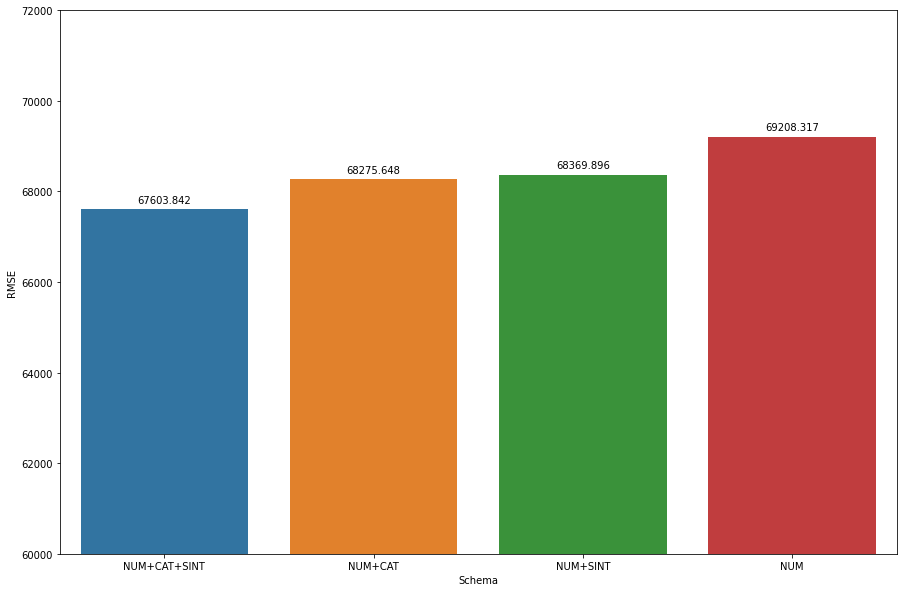

In [46]:
fig, ax = plt.subplots(figsize = (15,10))
ax.set_ylim(60_000, 72_000)

show_values(sns.barplot(x='Schema', y='RMSE', data=rmse, ci=None))


In [47]:
rmse['RMSE'].sort_values()

2    67603.841828
0    68275.648112
3    68369.896404
1    69208.317308
Name: RMSE, dtype: float64

Как видно из графика, метрика RMSE распределилась следующим образом(от лучшей к худшей):
- модель, которой был передан набор всех данных из исходного набора + синтетические признаки;
- модель, которой был передан набор всех данных из исходного набора;
- модель, которой был передан набор только количественных данных + синтетческие признаки;
- модель, которой был передан набор только количественных данных из исходного набора;

In [48]:
mae_list = [
    ['NUM+CAT', model.summary.meanAbsoluteError],
    ['NUM', model_num.summary.meanAbsoluteError],
    ['NUM+CAT+SINT', model_sint.summary.meanAbsoluteError],
    ['NUM+SINT', model_sint_num.summary.meanAbsoluteError]
]

mae = pd.DataFrame(mae_list, columns = ['Schema', 'MAE']).sort_values(by='MAE')

mae

,Schema,MAE
2,NUM+CAT+SINT,48897.450948
0,NUM+CAT,49529.281741
3,NUM+SINT,49781.185154
1,NUM,50642.131508


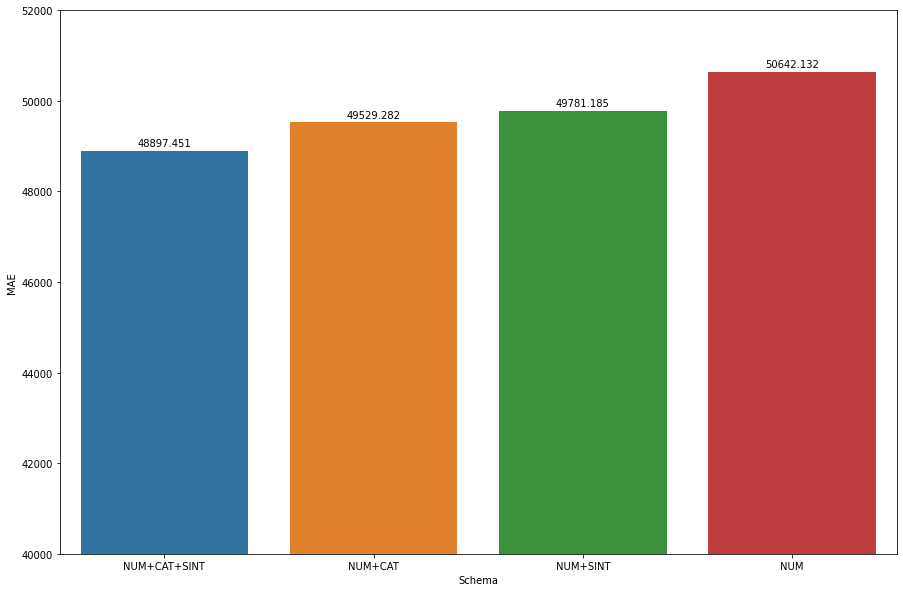

In [49]:
fig, ax = plt.subplots(figsize = (15,10))
ax.set_ylim(40_000, 52_000)

show_values(sns.barplot(x='Schema', y='MAE', data=mae, ci=None))


Как видно из графика, метрика MAE распределилась следующим образом(от лучшей к худшей):

модель, которой был передан набор всех данных из исходного набора + синтетические признаки;
модель, которой был передан набор всех данных из исходного набора;
модель, которой был передан набор только количественных данных + синтетческие признаки;
модель, которой был передан набор только количественных данных из исходного набора;

In [50]:
r2_list = [
    ['NUM+CAT', model.summary.r2],
    ['NUM', model_num.summary.r2],
    ['NUM+CAT+SINT', model_sint.summary.r2],
    ['NUM+SINT', model_sint_num.summary.r2]
]

r2 = pd.DataFrame(r2_list, columns = ['Schema', 'R2']).sort_values(by='R2', ascending=False)

r2

,Schema,R2
2,NUM+CAT+SINT,0.653222
0,NUM+CAT,0.646296
3,NUM+SINT,0.645319
1,NUM,0.636566


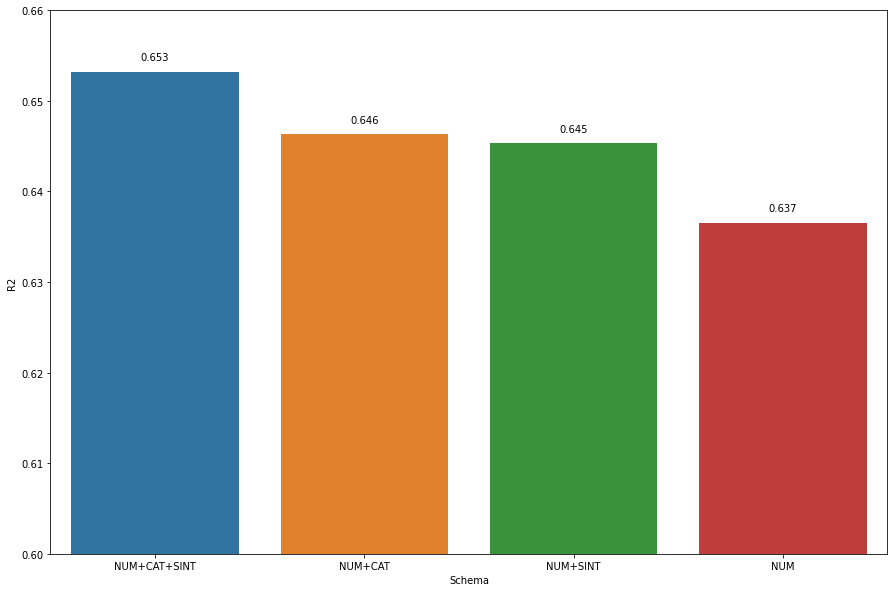

In [51]:
fig, ax = plt.subplots(figsize = (15,10))
ax.set_ylim(0.6, 0.66)

show_values(sns.barplot(x=r2['Schema'], y=r2['R2']))

In [52]:
spark.stop()

Как видно из графика, метрика R2 распределилась следующим образом(от лучшей к худшей):

модель, которой был передан набор всех данных из исходного набора + синтетические признаки;
модель, которой был передан набор всех данных из исходного набора;
модель, которой был передан набор только количественных данных + синтетческие признаки;
модель, которой был передан набор только количественных данных из исходного набора;

**Вывод:** Как видно из графиков выше, для всех трех ранее полученных метрик: RMSE, MAE и R2 справедлива следующая зависимость их распределения, в зависимости от набора данных преданных для обучения модели (далее модели перечислены от лучшего результата к худшему):
- модель, которой был передан набор всех данных из исходного набора + синтетические признаки;
- модель, которой был передан набор всех данных из исходного набора;
- модель, которой был передан набор только количественных данных + синтетческие признаки;
- модель, которой был передан набор только количественных данных из исходного набора.

Отсюда можно прийти к выводу что категориальные данные, содержащиеся в столбце 'ocean_proximity' улучшают обобщающую способность модели и повышают исследуемые метрики. 
СТоит также обратить внимание, что использование синтетических признаков, также повышают точность прогноза модели и практически могут нивелировать отстутсвие категориального признака в передаваемых для обучения данных.

**Общий вывод:** 
    Целью данного проекта являлось:
- обучить модель линейной регрессии на данных о жилье в Калифорнии в 1990 году;
- выполнить предсказание медианной стоимость дома в жилом массиве;
- обучить модель и сделать предсказания на тестовой выборке;
- для оценки качества модели использовать метрики RMSE, MAE и R2.

В рамках выполнения данного проекта:
- инициализована локальная Spark-сессия;
- загружены необходимые для выполнения исследования данные. Выведены типы данных параметров методами pySpark. Выведены базовые статистики по столбцам датафрейма.
- в рамках предобработки данных датасет проверен на наличие пропусков. Выявленные пропуски в столбце 'total_bedroms', заменены на медианное значение по данному столбцу. Также столбец 'ocean_proximity' содержащий категориальные значения, обработан с помощью StringIndexer и OneHotEncoder, количественные признаки обработаны с помощью StandardScaler. Все трансформированные признаки собраны в итоговый вектор.
- получены предсказания таргета, с использованием модели линейной регрессии, на 4-х наборах данных:
1. весь набор признаков, содержащийся в исходном наборе данных;
2. использование только количественных признаков, содержащихся в исходном наборе;
3. использование набора всех признаков, с учетом добавленных синтетических данных;
4. использование только количественных признаков, с учетом добавленных синтетических данных.
Качество работы модели оценено метриками RMSE, MAE и R2.

- для всех трех полученных метрик: RMSE, MAE и R2 справедлива следующая зависимость их распределения, в зависимости от набора данных преданных для обучения модели (далее модели перечислены от лучшего результата к худшему):

1. модель, которой был передан набор всех данных из исходного набора + синтетические признаки (RMSE = 67_604 , MAE = 48_897, R2 = 0.653);
2. модель, которой был передан набор всех данных из исходного набора (RMSE = 68_276, MAE = 49_529 , R2 = 0.646);
3. модель, которой был передан набор только количественных данных + синтетческие признаки (RMSE = 68_370, MAE = 49_781, R2 = 0.645);
4. модель, которой был передан набор только количественных данных из исходного набора (RMSE = 69_208, MAE = 50_642 , R2 = 0.637)

Отсюда можно прийти к выводу что категориальные данные, содержащиеся в столбце 'ocean_proximity' улучшают обобщающую способность модели и повышают исследуемые метрики. Стоит обратить внимание, что использование синтетических признаков, также повышают точность прогноза модели и может практически нивелировать отстутсвие категориального признака, в передаваемых для обучения данных.